In [1]:
# ML Tools
import numpy as np 
import pandas as pd 
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# To prepare data
import re
from nltk.corpus import stopwords
from sklearn.utils import shuffle
# import nltk
# nltk.download('stopwords')
# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# Train Tools
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle

# other settings
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

2022-11-05 18:43:40.459952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Input Data

In [3]:
mdata = pd.read_csv('data/f_m_names.csv')
df = shuffle(mdata)
df = df.dropna()
train = df[:5000]
test = df[5000:6264]

y_test = test['label']

In [4]:
train.head()

,text,label
2457,Исаев Сергей Константинович,1
4346,Голикова Евгения Фёдоровна,0
3600,Титова Злата Егоровна,0
495,Котов Александр Михайлович,1
731,Попов Ярослав Алексеевич,1


## 2. Data Preprocessing

In [5]:
# clean data from punctuation marks and convert to lowercase

stopwords_rus = set(stopwords.words("russian"))

def clean_text(text):
    text = text.lower() # convert to lowercase
    text = re.sub("[^а-я]", " ", text)
    words = [word for word in text.split() if word not in stopwords_rus]
    text = " ".join(words)
    return text

clean_train_reviews = train['text'].map(clean_text)
clean_test_reviews = test['text'].map(clean_text)

## 3. Tokenization

In [6]:
# prepare data for training
MAX_SEQUENCE_LENGTH_NAMES = 36
vocab_size_names = 5793

tokenizer = Tokenizer()

tokenizer.fit_on_texts(clean_train_reviews + clean_train_reviews)

text_sequences = tokenizer.texts_to_sequences(clean_train_reviews)
train_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH_NAMES, padding='post')

text_sequences = tokenizer.texts_to_sequences(clean_test_reviews)
test_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH_NAMES, padding='post')

## 4. Build Model

In [7]:
def model_name():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size_names, 16, input_length=MAX_SEQUENCE_LENGTH_NAMES))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.005)))
    model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(8, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
    return model

## 5. Compile and Train

In [27]:
model = model_name()
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 36, 16)            92688     
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 64)                1088      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 8)                 264       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                      

In [20]:
X_val = train_inputs[:4000]
X_train = train_inputs[4000:]

y_val = np.array(train['label'].iloc[:4000])
y_train = np.array(train['label'].iloc[4000:])

In [25]:
checkpoint_path = "pretrained_models/training_names/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)
history = model.fit(X_train,
                    y_train,
                    epochs=35,
                    batch_size=512,
                    validation_data=[X_val, y_val],
                    verbose=1,
                    callbacks=[cp_callback])

Epoch 1/35
2/2 [==============================] - 0s 336ms/step - loss: 0.7340 - acc: 0.5150 - val_loss: 0.7325 - val_acc: 0.6750
Epoch 2/35
2/2 [==============================] - 0s 67ms/step - loss: 0.7283 - acc: 0.8770 - val_loss: 0.7266 - val_acc: 0.9862
Epoch 3/35
2/2 [==============================] - 0s 67ms/step - loss: 0.7222 - acc: 0.9990 - val_loss: 0.7227 - val_acc: 0.8062
Epoch 4/35
2/2 [==============================] - 0s 68ms/step - loss: 0.7176 - acc: 0.9240 - val_loss: 0.7184 - val_acc: 0.8435
Epoch 5/35
2/2 [==============================] - 0s 64ms/step - loss: 0.7127 - acc: 0.9860 - val_loss: 0.7137 - val_acc: 0.9235
Epoch 6/35
2/2 [==============================] - 0s 68ms/step - loss: 0.7074 - acc: 1.0000 - val_loss: 0.7083 - val_acc: 0.9545
Epoch 7/35
2/2 [==============================] - 0s 66ms/step - loss: 0.7013 - acc: 1.0000 - val_loss: 0.7024 - val_acc: 0.9805
Epoch 8/35
2/2 [==============================] - 0s 67ms/step - loss: 0.6947 - acc: 1.0000 - va

## 6. Predict

In [30]:
checkpoint_path = "pretrained_models/training_names/cp.ckpt"
model.load_weights(checkpoint_path)

40/40 [==============================] - 0s 939us/step
1.0


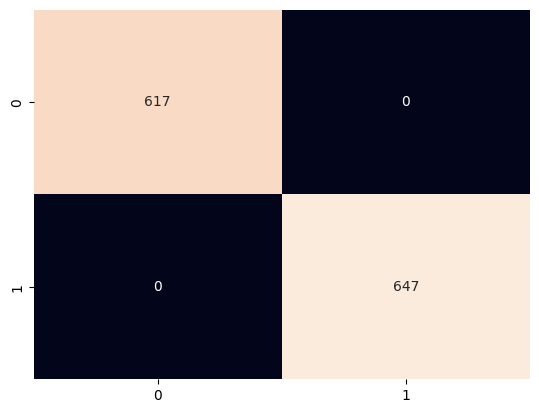

In [31]:

predictions = np.rint(model.predict(test_inputs)).astype('int32').squeeze()

cfm = confusion_matrix(y_test, predictions)
sns.heatmap(cfm, annot=True, fmt="d", cbar=False)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)